# Project Explanation

Prepare Gaussian blurs, and plot vertical and horizontal lines on top.

Then create line images with angles $ \theta \in [ -\frac{\pi}{2}, \frac{\pi}{2} ] $.

Train a model on Gaussian blurs with 100 percent accuracy on training and test sets.

Then let the model make a guess on the line images towards being a vertical or a horizontal line (even though it's neither).

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [91]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Gaussian blurs

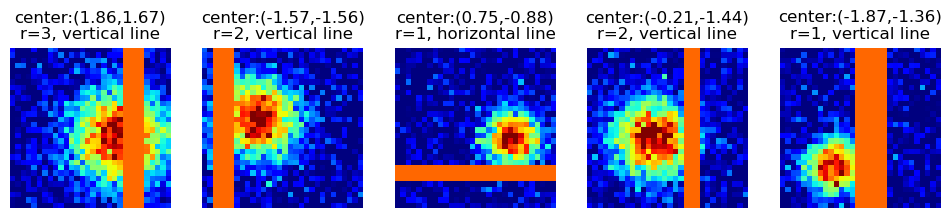

In [95]:
# prepare a mesh grid for the blurs
num_gauss = 5000
temp = np.linspace(-4, 4, 30) 
X, Y = np.meshgrid(temp, temp) # for pixel densities

# to have a blur, we need a center
images = np.zeros((num_gauss, len(temp), len(temp)))
centers = np.zeros((num_gauss, 2))
line_vertical = np.zeros(num_gauss) # 1 if vertical, 0 if horizontal
widths = [1,2,3]
for i in range(num_gauss):
    # random center
    center = 4*np.random.random(2) - 2 # averaged around the origin
    pixel_values = np.exp(-((X - center[0])**2 + (Y - center[1])**2) / (2*widths[i % 3]) ) # pixel densities getting 
    # smaller as we're further away from the center
    # add some noise 
    pixel_values += np.random.randn(len(temp), len(temp))/10

    # now add lines
    thickness = np.random.choice(range(2,6))
    is_vertical = np.random.randint(low=0, high=2)
    start_pixel = np.random.randint(low=2, high=len(temp)-thickness+1)
    if is_vertical:
        pixel_values[:,start_pixel:(start_pixel+thickness+1)] = 0.8
    else:
        pixel_values[start_pixel:(start_pixel+thickness+1),:] = 0.8
    
    # store the images
    images[i,:,:] = pixel_values
    centers[i,:] = center
    line_vertical[i] = is_vertical

# plot some images to see if this worked
random_images = np.random.choice(range(num_gauss), size=5, replace=False)
fig, ax = plt.subplots(1,5, figsize=[12,4])
for i in range(5):
    temp_txt = "horizontal" if line_vertical[random_images[i]] == 0 else "vertical"
    temp_txt += " line"
    ax[i].imshow(images[random_images[i],:,:], vmin=0, vmax=1, cmap='jet')
    ax[i].set_title(f"center:({centers[i,0]:.2f},{centers[i,1]:.2f})\nr={widths[random_images[i] % 3]}, {temp_txt}")
    ax[i].axis("off")

plt.show()

## Normalize the images to [0,1]

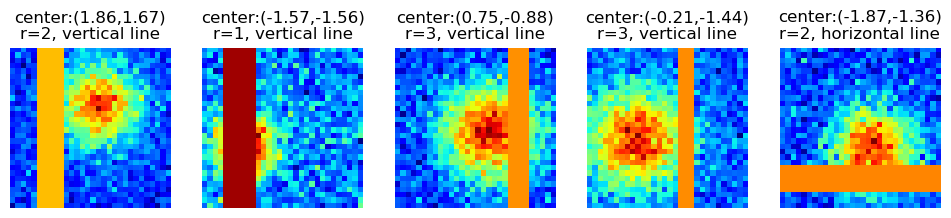

In [96]:
for i in range(images.shape[0]):
    images[i,:,:] = (images[i,:,:] - np.min(images[i,:,:])) / (np.max(images[i,:,:]) - np.min(images[i,:,:]))

# plot once more
random_images = np.random.choice(range(num_gauss), size=5, replace=False)
fig, ax = plt.subplots(1,5, figsize=[12,4])
for i in range(5):
    temp_txt = "horizontal" if line_vertical[random_images[i]] == 0 else "vertical"
    temp_txt += " line"
    ax[i].imshow(images[random_images[i],:,:], vmin=0, vmax=1, cmap='jet')
    ax[i].set_title(f"center:({centers[i,0]:.2f},{centers[i,1]:.2f})\nr={widths[random_images[i] % 3]}, {temp_txt}")
    ax[i].axis("off")

plt.show()

## Create model class

In [78]:
class CNN_model(nn.Module):
    def __init__(self, printtoggle=False):
        super().__init__()

        self.print = printtoggle
        # conv layer 1
        self.conv1  = nn.Conv2d(1,8, kernel_size=3, stride=1, padding=0)
        self.bnorm1 = nn.BatchNorm2d(8)
        # output size = ((30 + 2*0 - 3) // 1 + 1) // 2 = 14

        # conv layer 2
        self.conv2  = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0)
        self.bnorm2 = nn.BatchNorm2d(16)
        # output size = ((14 + 2*0 - 3) // 1 + 1) // 2 = 6
        
        # flatten
        self.flatten = nn.Flatten()

        # fc layer 1
        self.fc1 = nn.Linear(16*6*6, 100)
        self.fc2 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 1) # will decide if vertical or not

    def forward(self, x):
        # conv layer 1
        x = F.max_pool2d(self.conv1(x),2)
        x = F.relu(self.bnorm1(x))
        print(f"Conv Layer 1 Shape: {list(x.shape)}") if self.print else None

        # conv layer 2
        x = F.max_pool2d(self.conv2(x),2)
        x = F.relu(self.bnorm2(x))
        print(f"Conv Layer 2 Shape: {list(x.shape)}") if self.print else None
        
        # flatten
        x = self.flatten(x)

        # fc layer 1
        x = F.relu(self.fc1(x))
        print(f"FC Layer 1 Shape: {list(x.shape)}") if self.print else None

        # fc layer 2
        x = F.relu(self.fc2(x))
        print(f"FC Layer 2 Shape: {list(x.shape)}") if self.print else None

        # fc layer 3 (no activation since BCEWithLogitsLoss will apply it)
        x = self.fc3(x)
        print(f"FC Layer 3 Shape: {list(x.shape)}") if self.print else None

        return x

In [80]:
# test if the model class works
# model = CNN_model()
# temp_out = model(torch.tensor(images[0,:,:]).float().view(-1, 1, 30, 30))
# print(temp_out)

## Prepare DataLoaders

In [104]:
data_T = torch.tensor(images).reshape(-1,1,30,30).float()
labels_T = torch.tensor(line_vertical).long()[:,None]
# print(data.shape, labels.shape)

data_train, data_test, labels_train, labels_test = train_test_split(data_T, labels_T, train_size=0.8, shuffle=True)

train_pre = TensorDataset(data_train, labels_train)
test_pre  = TensorDataset(data_test, labels_test)

train_loader = DataLoader(train_pre, batch_size=32, drop_last=True, shuffle=True)
test_loader  = DataLoader(test_pre, batch_size=test_pre.tensors[0].shape[0])

## Model Creation Function

In [87]:
def create_model():
    model = CNN_model()
    lossfun = nn.BCEWithLogitsLoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

    return model, lossfun, optimizer

In [88]:
create_model()

(CNN_model(
   (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
   (bnorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
   (bnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (fc1): Linear(in_features=576, out_features=100, bias=True)
   (fc2): Linear(in_features=100, out_features=10, bias=True)
   (fc3): Linear(in_features=10, out_features=1, bias=True)
 ),
 BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0.0001
 ))

## Training Function

In [124]:
num_epochs = 20

def train_model():

    # create model, lossfun, optimizer
    model, lossfun, optimizer = create_model()

    # keep losses and accuracies
    train_acc    = []
    test_acc      = []
    train_losses = []
    test_losses   = []

    # start training
    for i in range(num_epochs):
        print(f"Epoch {i+1}/{num_epochs}")
        start_time = time.process_time()
        # put model in training mode
        model.train()

        # batch losses and accuracy
        batch_loss = []
        batch_acc = []

        # start batch feeding
        for batch, labels in train_loader:

            # feed forward
            yHat = model(batch)

            # get loss
            loss = lossfun(yHat, labels.float())

            # store loss
            batch_loss.append(loss.item())

            # get batch accuracy
            batch_pred = yHat>0
            batch_acc.append(
                100*torch.mean(
                    (batch_pred == labels).float().detach()
                )
            )

            # back prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # end of batches
        model.eval()

        # store average training accuracy and losses
        train_losses.append(np.mean(batch_loss))
        train_acc.append(np.mean(batch_acc))

        # get evaluations from the dev set
        X_test, y_test = next(iter(test_loader))
        X_test = X_test.to(device)
        yHat_test = model(X_test)
        yHat_test = yHat_test.cpu()

        # store dev loss
        test_loss = lossfun(yHat_test, y_test.float())
        test_losses.append(test_loss.item())

        # store dev accuracy
        test_pred = (yHat_test > 0)
        test_acc.append(
            100*torch.mean(
                (test_pred == y_test).float().detach()
            )
        )
        print(f"Training done in {time.process_time() - start_time} seconds")
    # end of training

    # return the model and statistics
    return train_losses, test_losses, train_acc, test_acc, model

In [125]:
# train model and see the losses and accuracies
train_losses, test_losses, train_acc, test_acc, model = train_model()

Epoch 1/20
Training done in 3.40625 seconds
Epoch 2/20
Training done in 3.640625 seconds
Epoch 3/20
Training done in 3.640625 seconds
Epoch 4/20
Training done in 3.65625 seconds
Epoch 5/20
Training done in 3.453125 seconds
Epoch 6/20
Training done in 3.578125 seconds
Epoch 7/20
Training done in 3.671875 seconds
Epoch 8/20
Training done in 3.40625 seconds
Epoch 9/20
Training done in 3.640625 seconds
Epoch 10/20
Training done in 3.328125 seconds
Epoch 11/20
Training done in 3.4375 seconds
Epoch 12/20
Training done in 3.65625 seconds
Epoch 13/20
Training done in 3.484375 seconds
Epoch 14/20
Training done in 3.546875 seconds
Epoch 15/20
Training done in 3.296875 seconds
Epoch 16/20
Training done in 3.1875 seconds
Epoch 17/20
Training done in 3.921875 seconds
Epoch 18/20
Training done in 3.6875 seconds
Epoch 19/20
Training done in 3.6875 seconds
Epoch 20/20
Training done in 3.28125 seconds


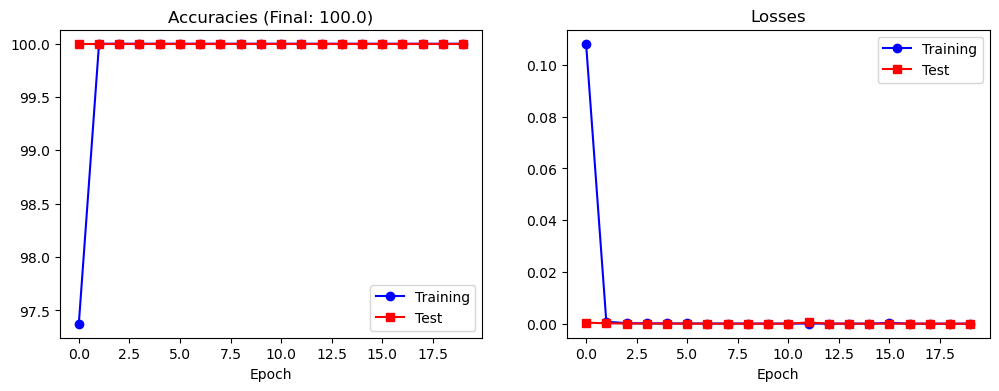

In [126]:
plt.figure(figsize=[12,4])

plt.subplot(121)
plt.plot(train_acc, "bo-")
plt.plot(test_acc, "rs-")
plt.title(f"Accuracies (Final: {test_acc[-1]})")
plt.xlabel("Epoch")
plt.legend(["Training", "Test"])

plt.subplot(122)
plt.plot(train_losses, "bo-")
plt.plot(test_losses, "rs-")
plt.title("Losses")
plt.xlabel("Epoch")
plt.legend(["Training", "Test"])

## Create Line Images

**Tip:** skimage.draw.line_aa

In [128]:
from skimage.draw import line_aa
?line_aa

Signature: line_aa(r0, c0, r1, c1)
Docstring:
Generate anti-aliased line pixel coordinates.

Parameters
----------
r0, c0 : int
    Starting position (row, column).
r1, c1 : int
    End position (row, column).

Returns
-------
rr, cc, val : (N,) ndarray (int, int, float)
    Indices of pixels (`rr`, `cc`) and intensity values (`val`).
    ``img[rr, cc] = val``.

References
----------
.. [1] A Rasterizing Algorithm for Drawing Curves, A. Zingl, 2012
       http://members.chello.at/easyfilter/Bresenham.pdf

Examples
--------
>>> from skimage.draw import line_aa
>>> img = np.zeros((10, 10), dtype=np.uint8)
>>> rr, cc, val = line_aa(1, 1, 8, 8)
>>> img[rr, cc] = val * 255
>>> img
array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 255,  74,   0,   0,   0,   0,   0,   0,   0],
       [  0,  74, 255,  74,   0,   0,   0,   0,   0,   0],
       [  0,   0,  74, 255,  74,   0,   0,   0,   0,   0],
       [  0,   0,   0,  74, 255,  74,   0,   0,   0,   0],
       [  0,   0,   

In [141]:
# generate 60 30x30 line images
line_images = np.zeros((60, 30, 30))
slopes = np.zeros(60)
# Signature: line_aa(r0, c0, r1, c1)
# Docstring:
# Generate anti-aliased line pixel coordinates.

# Parameters
# ----------
# r0, c0 : int
#     Starting position (row, column).
# r1, c1 : int
#     End position (row, column).

# Returns
# -------
# rr, cc, val : (N,) ndarray (int, int, float)
#     Indices of pixels (`rr`, `cc`) and intensity values (`val`).
#     ``img[rr, cc] = val``.

for i in range(30):
    rr, cc, val = line_aa(29-i, 0, 
                             i, 29)
    line_images[i, rr, cc] = val
    slopes[i] = -(i - (29 - i)) / (29 - 0) 
for i in range(30):
    rr, cc, val = line_aa(29, i,
                           0, 29-i)
    line_images[30+i, rr , cc] = val
    slopes[30+i] = -(0 - 29) / ((29-i) - i)   

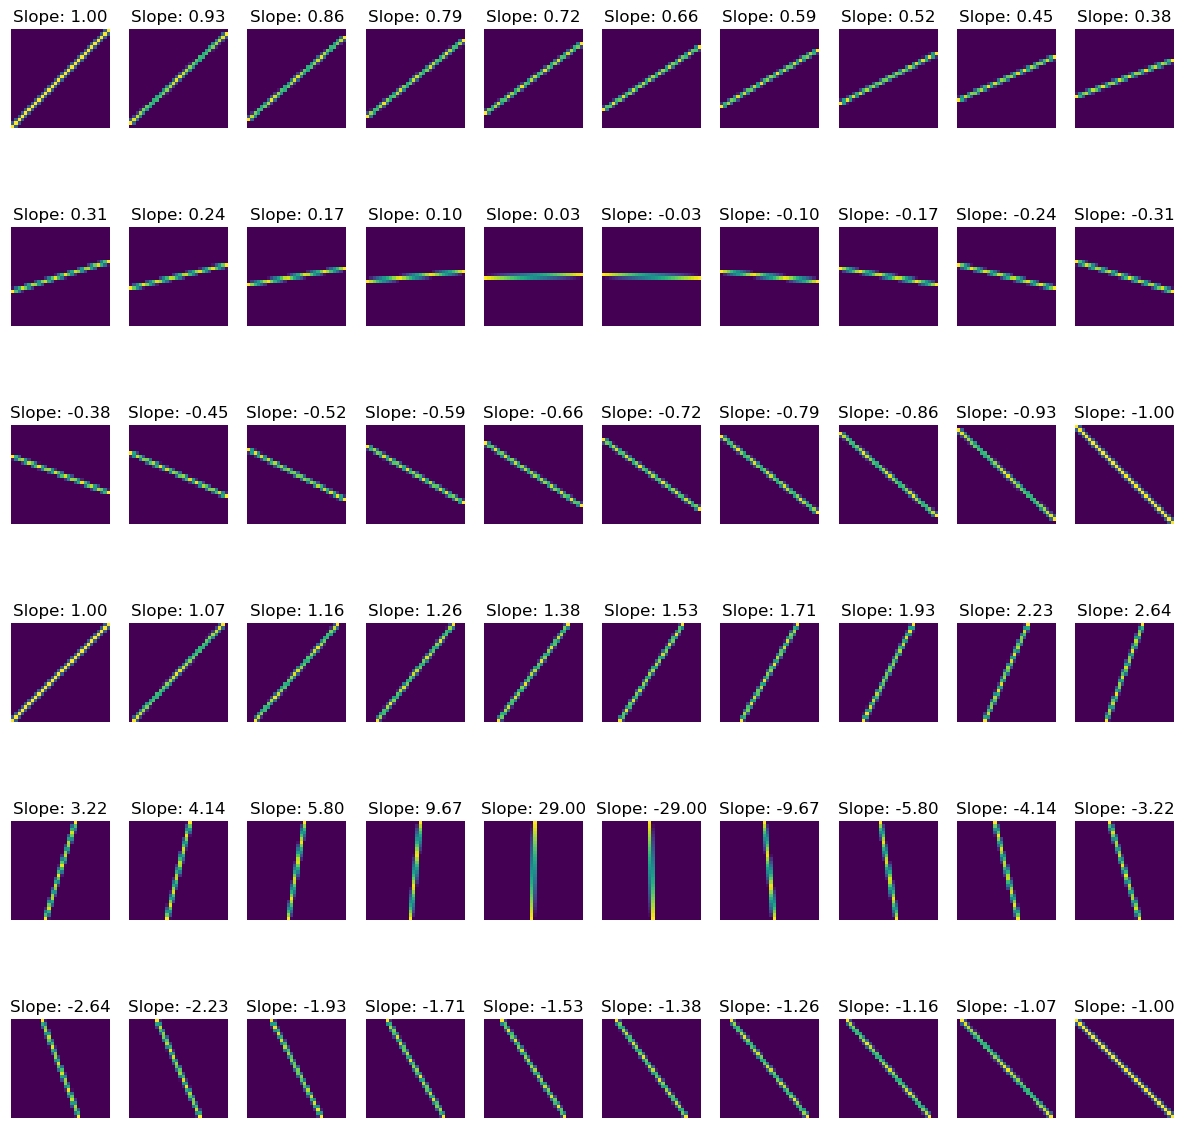

In [142]:
# see the lines
fig, axs = plt.subplots(6, 10, figsize=[15,15])

for i in range(6):
    for j in range(10):
        axs[i,j].imshow(line_images[10*i+j,:,:])
        axs[i,j].set_title(f"Slope: {slopes[10*i + j]:.2f}")
        axs[i,j].axis("off")

## Feed images to the model and collect its guesses

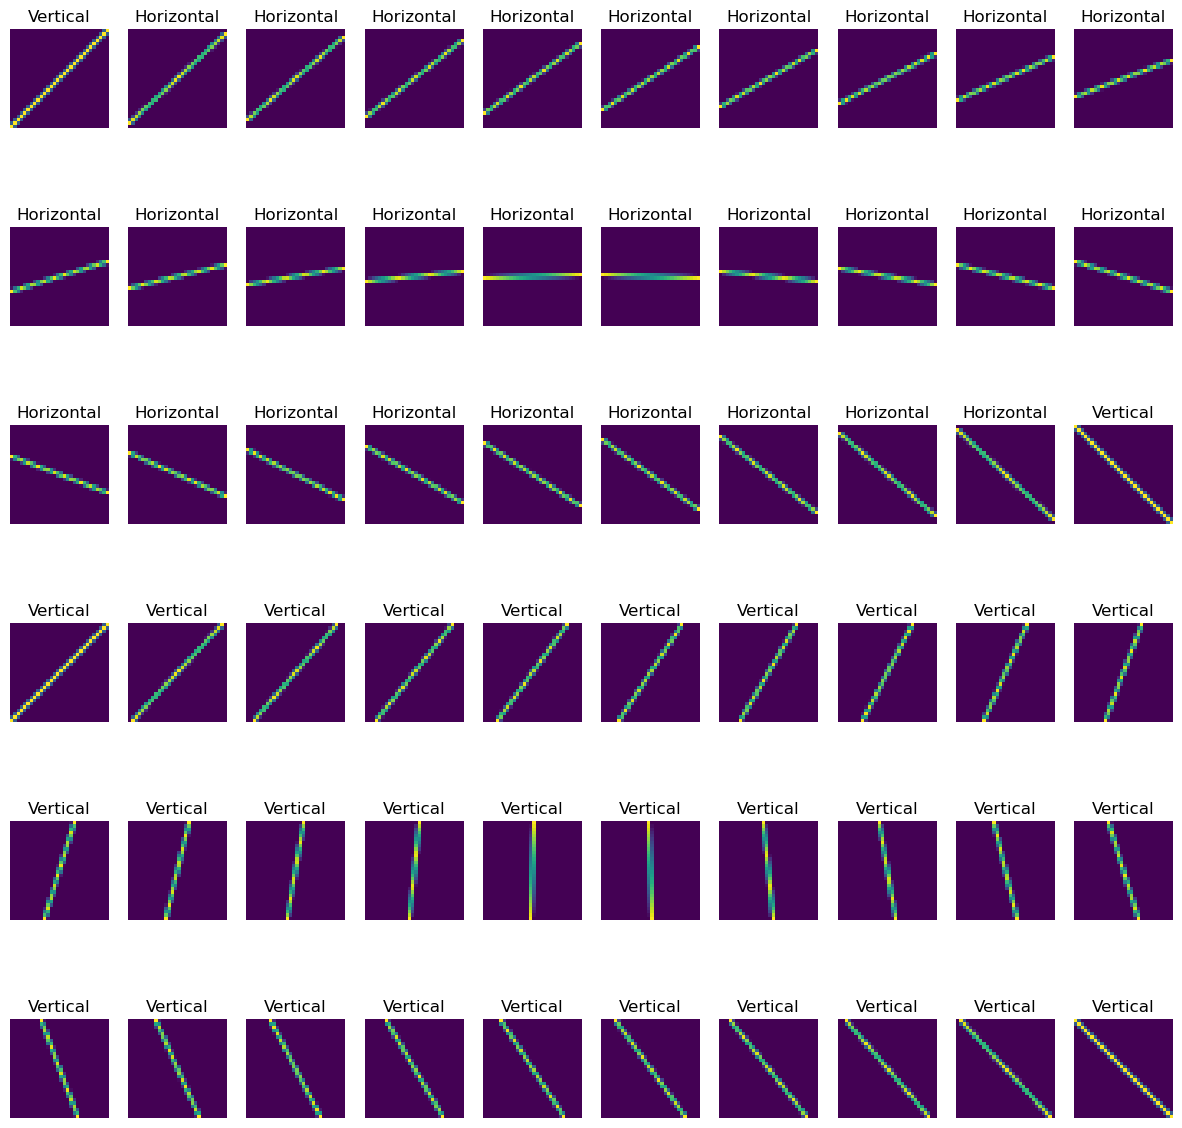

In [148]:
# get predictions once
line_images_T = torch.tensor(line_images).float().view(-1,1,30,30)
predictions = model(line_images_T)
predictions = predictions > 0
# plot the images with predictions in the title
fig, axs = plt.subplots(6, 10, figsize=[15,15])

for i in range(6):
    for j in range(10):
        axs[i,j].imshow(line_images[10*i+j,:,:])
        axs[i,j].set_title(f"{"Vertical" if predictions[10*i+j] else "Horizontal"}")
        axs[i,j].axis("off")

In [151]:
predictions

tensor([[ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True

## Get a large sample of predictions and plot probabilities of predicting vertical for each line

In [157]:
num_exp = 1000

# rows are images, columns are experiments
pred_matrix = np.zeros((line_images_T.shape[0], num_exp), dtype=int)

for exp_i in range(num_exp):
    
    # feed images to the model
    predictions = model(line_images_T)
    
    # record the predictions of being vertical 
    predictions = (predictions > 0).long().numpy()

    # store experiment outcomes in pred_matrix
    pred_matrix[:,exp_i] = predictions.T

# get empirical ratios (i.e. empirical probability) of verticals in the predictions for each image
avg_predictions = np.mean(pred_matrix, axis=1)

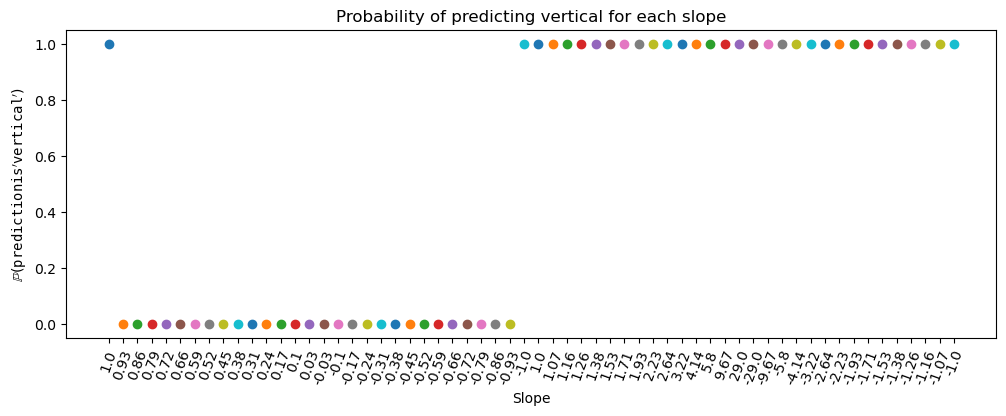

In [181]:
# plot the probabilities for each image
fig, ax = plt.subplots(1,1,figsize=[12,4])
ax.set_title("Probability of predicting vertical for each slope")
for i in range(line_images_T.shape[0]):
    ax.scatter(i, avg_predictions[i])
ax.set_xlabel("Slope")
ax.set_ylabel(r"$\mathbb{P}(\mathtt{prediction is 'vertical'})$")
ax.set_xticks(range(line_images_T.shape[0]), [str(np.around(x, decimals=2)) for x in slopes])
ax.tick_params(axis='x', labelrotation=70)
plt.show()

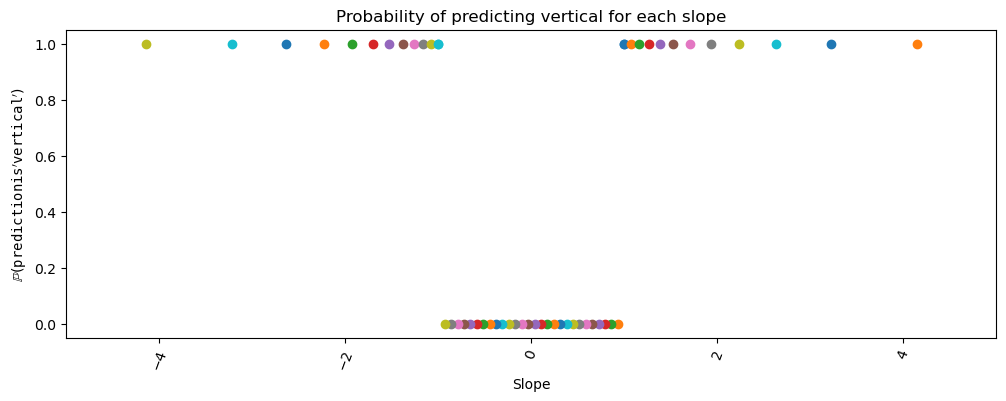

In [188]:
# plot the probabilities for each image
fig, ax = plt.subplots(1,1,figsize=[12,4])
ax.set_title("Probability of predicting vertical for each slope")
for i in range(line_images_T.shape[0]):
    ax.scatter(slopes[i], avg_predictions[i])
ax.set_xlabel("Slope")
ax.set_ylabel(r"$\mathbb{P}(\mathtt{prediction is 'vertical'})$")
ax.set_xlim(left=-5.0, right=5.0)
#ax.set_xticks(range(line_images_T.shape[0]), [str(np.around(x, decimals=2)) for x in slopes])
ax.tick_params(axis='x', labelrotation=70)
plt.show()

## Results

Any line with slope $\theta \in (-\frac{\pi}{2},\frac{\pi}{2})$ is estimated to be horizontal. 

Any line with slope $\theta \in (-\pi,-\frac{\pi}{2}] \cup [\frac{\pi}{2},\pi) $ is estimated to be vertical. 